In [1]:
# apt-get -y install libgl1-mesa-glx
# apt-get install libglib2.0-0
# pip install MarkupSafe==2.0.1
import os
import cv2
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import torchvision.transforms as transforms
import torch
import random
import torch.nn.functional as F
import re
import math

from diffusers import DPMSolverMultistepScheduler
from models.stablediffusion import StableDiffusionPipeline

from matplotlib import pyplot as plt

# Stable Diffusion CAM

### Model Setting

In [2]:
def auto_device(obj = torch.device('cpu')):
    if isinstance(obj, torch.device):
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        return obj.to('cuda')

    return obj

def set_seed(seed: int) -> torch.Generator:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    gen = torch.Generator(device=auto_device())
    gen.manual_seed(seed)
    return gen

# Model loading...
# model_id = "stabilityai/stable-diffusion-2-1"
model_id = "CompVis/stable-diffusion-v1-4"


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPUs 2 and 3 to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
net = torch.nn.DataParallel(pipe).to(device)
pipe = net.module
pipe.unet.config.sample_size = 64

prompt = "a photo of an astronaut riding a horse on mars"
# prompt = "a male nurse"

print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8069.85it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Current cuda device: 0
Count of using GPUs: 4


### Choosing the U-Net layer and Setting the hook register

In [ ]:
import trace

# Hook Setting
gradients = dict()
activations = dict()

def backward_hook(module, grad_input, grad_output):
    print("Backwarding!!")
    gradients['value'] = grad_output[0]

def forward_hook( module, input, output):
    activations['value'] = output


block = "mid"
layer = "resnets"
block_num = 1
layer_num =1

unet_config = {
    "up" : [
        {"resnets":[1,2,3], "upsamplers" : [1]},
        {"attentions": [1,2,3], "resnets":[1,2,3], "upsamplers" : [1]},
        {"attentions": [1,2,3], "resnets":[1,2,3], "upsamplers" : [1]},
        {"attentions": [1,2,3], "resnets":[1,2,3]},
            ],
    "down" : [
        {"attentions": [1,2], "resnets":[1,2], "downsamplers" : [1]},
        {"attentions": [1,2], "resnets":[1,2], "downsamplers" : [1]},
        {"attentions": [1,2], "resnets":[1,2], "downsamplers" : [1]},
        {"resnets":[1,2]},
        ],
    "mid" : [{"resnets":[1,2]}]
    }

if block == "down":
    # In the case of diffusion
    if layer == "attentions":
        pipe.unet.down_blocks[block_num-1].attention[layer_num-1].register_forward_hook(forward_hook)
        pipe.unet.down_blocks[block_num-1].attention[layer_num-1].register_backward_hook(backward_hook)
    elif layer == "resnets":
        pipe.unet.down_blocks[block_num-1].resnets[layer_num-1].register_forward_hook(forward_hook)
        pipe.unet.down_blocks[block_num-1].resnets[layer_num-1].register_backward_hook(backward_hook)
    elif layer == "downsamplers":
        pipe.unet.down_blocks[block_num-1].downsamplers[0].register_forward_hook(forward_hook)
        pipe.unet.down_blocks[block_num-1].downsamplers[0].register_backward_hook(backward_hook)
    else:
        raise ValueError("layer should be 'attention' or 'resnet' or 'downsampler'")

elif block == "up":
    if layer == "attentions":
        pipe.unet.up_blocks[block_num-1].attention[layer_num-1].register_forward_hook(forward_hook)
        pipe.unet.up_blocks[block_num-1].attention[layer_num-1].register_backward_hook(backward_hook)
    elif layer == "resnets":
        pipe.unet.up_blocks[block_num-1].resnets[layer_num-1].register_forward_hook(forward_hook)
        pipe.unet.up_blocks[block_num-1].resnets[layer_num-1].register_backward_hook(backward_hook)
    elif layer == "downsamplers":
        pipe.unet.up_blocks[block_num-1].upsamplers[0].register_forward_hook(forward_hook)
        pipe.unet.up_blocks[block_num-1].upsamplers[0].register_backward_hook(backward_hook)
    else:
        raise ValueError("layer should be 'attention' or 'resnet' or 'upsamplers'")
    
elif block == "mid":
    # one layer
    if layer == "attentions":
        pipe.unet.mid_block.attentions[0].register_forward_hook(forward_hook)
        pipe.unet.mid_block.attentions[0].register_full_backward_hook(backward_hook)
    # two layers
    elif layer == "resnets":
        pipe.unet.mid_block.resnets[layer_num-1].register_forward_hook(forward_hook)
        pipe.unet.mid_block.resnets[layer_num-1].register_full_backward_hook(backward_hook)
else:
    raise ValueError("block should be 'down' or 'up' or 'mid_block'")
    
layer_msg = f" {block}Block-{block_num}_{layer}-{layer_num}"

### Diffusion Grad Cam

In [13]:
def diffusion_gradcam(pipeline, prompt_txt, seed, num_step, step_vis, layer_message, save = False, time_steps = None):
    
    out, logit, all_images = pipeline(
        prompt_txt,
        num_inference_steps=num_step,
        generator=set_seed(seed),
        get_images_for_all_inference_steps = True,
        output_type = None,
        step_visualization_num = step_vis,
        time_steps = time_steps,
        visualization_mode = {'mode':"cam", 'mask':None , 'layer_vis' : False}
        )
    # print(logit.samplle.sum())
    logit.sample.sum().backward()

    guidance_scale = 7.5
    
    grad_pred_uncond, grad_pred_text = gradients['value'].data.chunk(2)
    gradients_ = grad_pred_uncond + guidance_scale * (grad_pred_text - grad_pred_uncond)

    if "attentions" in layer_message:
        actv_pred_uncond, actv_pred_text = activations['value'].sample.chunk(2)
        activations_ = actv_pred_uncond + guidance_scale * (actv_pred_text - actv_pred_uncond)
    else:
        actv_pred_uncond, actv_pred_text = activations['value'].data.chunk(2)
        activations_ = actv_pred_uncond + guidance_scale * (actv_pred_text - actv_pred_uncond)

    b, k, u, v = activations_.size()
    # Mean of feature maps
    alpha = gradients_.view(b, k, -1).mean(2)
    weights = alpha.view(b, k, 1, 1)
    saliency_map = (weights * activations_).sum(1, keepdim=True)

    h = pipeline.unet.config.sample_size * pipeline.vae_scale_factor
    w = pipeline.unet.config.sample_size * pipeline.vae_scale_factor

    saliency_map = F.relu(saliency_map)

    # Upsampling
    saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)

    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
    # normalization
    saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

    mask = saliency_map.cpu().data
    mask = (mask - mask.min()).div(mask.max() - mask.min()).data
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W,| 3]
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)

    noise_img = all_images[step_vis-1][0]
    org_img = out.images[0]

    raw_noise_img = cv2.resize(noise_img, (h, w), interpolation=cv2.INTER_LINEAR)
    raw_org_img = cv2.resize(org_img, (h, w), interpolation=cv2.INTER_LINEAR)

    # Image preprocessing
    
    # raw_img = np.float32(raw_img) / 255
    # img = raw_img.copy()[:, :, ::-1]
    noise_img = torch.from_numpy(np.ascontiguousarray(np.transpose(raw_noise_img, (2, 0, 1))))
    org_img = torch.from_numpy(np.ascontiguousarray(np.transpose(raw_org_img, (2, 0, 1))))

    transform_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    norm_noise_img = transform_norm(noise_img).unsqueeze(0)
    norm_org_img = transform_norm(org_img).unsqueeze(0)

    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # cam = heatmap + img.cpu()
    noise_cam = 1 * (1 - mask ** 0.8) * noise_img + (mask ** 0.8) * heatmap
    noise_gradcam = noise_cam.cpu().detach().squeeze(0)
    original_cam = 1 * (1 - mask ** 0.8) * org_img + (mask ** 0.8) * heatmap
    original_gradcam = original_cam.cpu().detach().squeeze(0)

    # Saving File
    # save_pth = os.path.join("./outputs/cam/", re.sub(" ", "_",layer_message))
    # save_pth = os.path.join("./outputs/exponential/", f"{layer_message}.png")
    save_pth = os.path.join("./outputs/choice/", f"{layer_message}.png")

    # if not os.path.isdir(save_pth):
    #     os.mkdir(save_pth)

    # Visualization
    plt.figure('Grad Cam', figsize=(10,4))
    plt.suptitle(f"{layer_message} | total step:{num_step} | visualization:{step_vis}")
    plt.subplot(1,3,1)
    plt.imshow(noise_gradcam.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(org_img.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(original_gradcam.permute(1, 2, 0))
    plt.axis("off")
    if save:
        # plt.savefig(os.path.join(save_pth, f"{num_step}_{step_vis}.png"))
        plt.savefig(save_pth)
    plt.show()

    return all_images, saliency_map

# Exponential Scheduler time steps

In [ ]:
num_step = 30
semantic_or_delicate = "semantic"
lamda =30
alpha = math.e ** (math.log(1000)/(num_step+lamda))
if semantic_or_delicate == "semantic":
    time_steps = [1000-int(alpha ** (i+1+lamda))for i in range(num_step)]
    time_steps.insert(0, 999)
    time_steps.pop(-1)
elif semantic_or_delicate == "delicate":
    time_steps = [int(alpha ** (i+1+lamda))for i in range(num_step)]
    time_steps.sort(reverse=True)
    if time_steps[0] == 1000:
        time_steps[0] = 999
else:
    raise ValueError
time_steps = np.array(time_steps)
time_steps = torch.from_numpy(time_steps).to(device)
time_steps

In [ ]:
time_steps1 = list(np.linspace(1,999, 6).astype(int))
time_steps2 = list(np.linspace(700,900, 24).astype(int))
time_steps1.extend(time_steps2)
time_steps1 = list(set(time_steps1))
# time_steps1.append(999)
# time_steps1.append(900)
time_steps1.sort(reverse=True)
time_steps1 = torch.from_numpy(np.array(time_steps1))
time_steps1

### Prompt

In [4]:
# prompt = "portrait photo of a cat astronaut"
# prompt = "portrait photo of a doctor singing a song"
# prompt = "portrait photo of a snowman eating a bread"
# prompt = "a portrait photo of a teddy bear playing soccer"
# prompt = "White Cat in the Snow by zoel"
# prompt = "a portrait photo of a cat getting off work"
# prompt = "a photo of an astronaut riding a horse on mars"
# prompt = "A photo of an elephants in the refrigerator"
# prompt = "A photo of a zebra and an elephant"
# prompt = "A photo of a person and a cat"
# prompt = "A photo of Lego Arnold Schwarzenegger"
# prompt = "A photo of a Mcdonalds castle"
prompt_txt = "a photo of an astronaut riding a horse"

In [5]:
import trace

# Hook Setting
gradients = dict()
activations = dict()

def backward_hook(module, grad_input, grad_output):
    print("Backwarding!!")
    gradients['value'] = grad_output[0]

def forward_hook( module, input, output):
    activations['value'] = output


unet_config = {
    "up" : [
        {"resnets":[1,2,3], "upsamplers" : [1]},
        {"attentions": [1,2,3], "resnets":[1,2,3], "upsamplers" : [1]},
        {"attentions": [1,2,3], "resnets":[1,2,3], "upsamplers" : [1]},
        {"attentions": [1,2,3], "resnets":[1,2,3]},
            ],
    "down" : [
        {"attentions": [1,2], "resnets":[1,2], "downsamplers" : [1]},
        {"attentions": [1,2], "resnets":[1,2], "downsamplers" : [1]},
        {"attentions": [1,2], "resnets":[1,2], "downsamplers" : [1]},
        {"resnets":[1,2]},
        ],
    "mid" : [{"resnets":[1,2]}]
    }
def layer_setting(block, layer, block_num, layer_num):
    if block == "down":
        # In the case of diffusion
        if layer == "attentions":
            pipe.unet.down_blocks[block_num].attentions[layer_num-1].register_forward_hook(forward_hook)
            pipe.unet.down_blocks[block_num].attentions[layer_num-1].register_backward_hook(backward_hook)
        elif layer == "resnets":
            pipe.unet.down_blocks[block_num].resnets[layer_num-1].register_forward_hook(forward_hook)
            pipe.unet.down_blocks[block_num].resnets[layer_num-1].register_backward_hook(backward_hook)
        elif layer == "downsamplers":
            pipe.unet.down_blocks[block_num].downsamplers[0].register_forward_hook(forward_hook)
            pipe.unet.down_blocks[block_num].downsamplers[0].register_backward_hook(backward_hook)
        else:
            raise ValueError("layer should be 'attention' or 'resnet' or 'downsampler'")

    elif block == "up":
        if layer == "attentions":
            pipe.unet.up_blocks[block_num].attentions[layer_num-1].register_forward_hook(forward_hook)
            pipe.unet.up_blocks[block_num].attentions[layer_num-1].register_backward_hook(backward_hook)
        elif layer == "resnets":
            pipe.unet.up_blocks[block_num].resnets[layer_num-1].register_forward_hook(forward_hook)
            pipe.unet.up_blocks[block_num].resnets[layer_num-1].register_backward_hook(backward_hook)
        elif layer == "upsamplers":
            pipe.unet.up_blocks[block_num].upsamplers[0].register_forward_hook(forward_hook)
            pipe.unet.up_blocks[block_num].upsamplers[0].register_backward_hook(backward_hook)
        else:
            raise ValueError("layer should be 'attention' or 'resnet' or 'upsamplers'")
        
    elif block == "mid":
        # one layer
        if layer == "attentions":
            pipe.unet.mid_block.attentions[0].register_forward_hook(forward_hook)
            pipe.unet.mid_block.attentions[0].register_full_backward_hook(backward_hook)
        # two layers
        elif layer == "resnets":
            pipe.unet.mid_block.resnets[layer_num-1].register_forward_hook(forward_hook)
            pipe.unet.mid_block.resnets[layer_num-1].register_full_backward_hook(backward_hook)
    else:
        raise ValueError("block should be 'down' or 'up' or 'mid_block'")
        
    layer_msg = f" {block}Block-{block_num}_{layer}-{layer_num}"
    return layer_msg

In [14]:
saliency_weights = torch.zeros((1,1,512,512),  dtype = torch.float16).to(pipe.device)
time_steps = None
num_step = 30
step_vis = 20

for block_name, block in unet_config.items():
        for block_num, layer_dict in enumerate(block):
                for layer_name, layer_lst in layer_dict.items():
                        for layer_num in layer_lst:
                                pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
                                pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
                                pipe = pipe.to("cuda")
                                net = torch.nn.DataParallel(pipe).to(device)
                                layer_msg = layer_setting(block_name, layer_name, block_num, layer_num)
                                all_images, sal_map = diffusion_gradcam(
                                        pipeline = pipe, 
                                        prompt_txt = prompt_txt, 
                                        seed =1, 
                                        num_step = num_step, 
                                        step_vis = step_vis, 
                                        layer_message = layer_msg,
                                        save = True,
                                        time_steps = time_steps,
                                        )
                                saliency_weights += sal_map

safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7666.33it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7810.62it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 9226.94it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7922.86it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8052.14it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8608.75it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7858.18it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 13808.41it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8365.30it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 14987.30it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7538.39it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8269.29it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7061.12it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7816.86it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 10725.16it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 16165.25it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 10071.22it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7958.83it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8714.14it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7785.77it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7936.78it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 18375.92it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 9388.48it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8702.52it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 13819.78it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7953.98it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8542.37it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 11544.33it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8467.23it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7270.96it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 9388.48it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8442.88it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7868.71it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8186.86it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 9213.19it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7463.17it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8660.80it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 9531.74it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8822.15it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7415.58it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7957.21it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 7556.82it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


safety_checker/pytorch_model.fp16.safetensors not found
Fetching 28 files: 100%|██████████| 28/28 [00:00<00:00, 8504.64it/s]
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Backwarding!!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


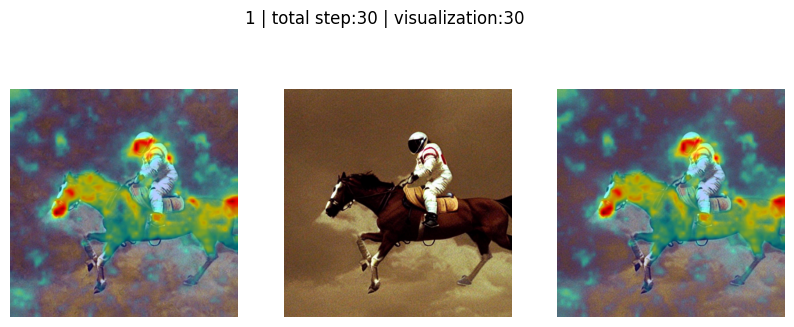

In [11]:
step_vis = 30
seed = 1
out, logit, all_images = pipe(
    prompt_txt,
    num_inference_steps=num_step,
    generator=set_seed(seed),
    get_images_for_all_inference_steps = True,
    output_type = None,
    step_visualization_num = step_vis,
    time_steps = time_steps,
    visualization_mode = {'mode':"cam", 'mask':None , 'layer_vis' : False}
    )


h = pipe.unet.config.sample_size * pipe.vae_scale_factor
w = pipe.unet.config.sample_size * pipe.vae_scale_factor

mask = saliency_weights.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W,| 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)

noise_img = all_images[step_vis-1][0]
org_img = out.images[0]

raw_noise_img = cv2.resize(noise_img, (h, w), interpolation=cv2.INTER_LINEAR)
raw_org_img = cv2.resize(org_img, (h, w), interpolation=cv2.INTER_LINEAR)

# Image preprocessing

# raw_img = np.float32(raw_img) / 255
# img = raw_img.copy()[:, :, ::-1]
noise_img = torch.from_numpy(np.ascontiguousarray(np.transpose(raw_noise_img, (2, 0, 1))))
org_img = torch.from_numpy(np.ascontiguousarray(np.transpose(raw_org_img, (2, 0, 1))))

transform_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
norm_noise_img = transform_norm(noise_img).unsqueeze(0)
norm_org_img = transform_norm(org_img).unsqueeze(0)

b, g, r = heatmap.split(1)
heatmap = torch.cat([r, g, b])
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# cam = heatmap + img.cpu()
noise_cam = 1 * (1 - mask ** 0.8) * noise_img + (mask ** 0.8) * heatmap
noise_gradcam = noise_cam.cpu().detach().squeeze(0)
original_cam = 1 * (1 - mask ** 0.8) * org_img + (mask ** 0.8) * heatmap
original_gradcam = original_cam.cpu().detach().squeeze(0)

# Saving File
# save_pth = os.path.join("./outputs/cam/", re.sub(" ", "_",layer_message))
# save_pth = os.path.join("./outputs/exponential/", f"{layer_message}.png")


# if not os.path.isdir(save_pth):
#     os.mkdir(save_pth)

# Visualization
plt.figure('Grad Cam', figsize=(10,4))
plt.suptitle(f"{1} | total step:{num_step} | visualization:{step_vis}")
plt.subplot(1,3,1)
plt.imshow(noise_gradcam.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(org_img.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(original_gradcam.permute(1, 2, 0))
plt.axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


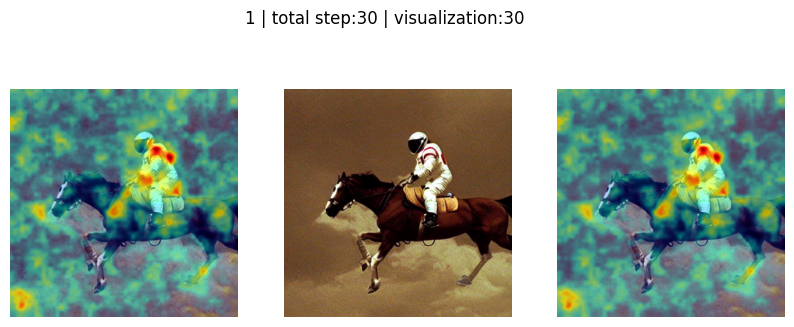

In [15]:
step_vis = 30
seed = 1
out, logit, all_images = pipe(
    prompt_txt,
    num_inference_steps=num_step,
    generator=set_seed(seed),
    get_images_for_all_inference_steps = True,
    output_type = None,
    step_visualization_num = step_vis,
    time_steps = time_steps,
    visualization_mode = {'mode':"cam", 'mask':None , 'layer_vis' : False}
    )


h = pipe.unet.config.sample_size * pipe.vae_scale_factor
w = pipe.unet.config.sample_size * pipe.vae_scale_factor

mask = saliency_weights.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W,| 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)

noise_img = all_images[step_vis-1][0]
org_img = out.images[0]

raw_noise_img = cv2.resize(noise_img, (h, w), interpolation=cv2.INTER_LINEAR)
raw_org_img = cv2.resize(org_img, (h, w), interpolation=cv2.INTER_LINEAR)

# Image preprocessing

# raw_img = np.float32(raw_img) / 255
# img = raw_img.copy()[:, :, ::-1]
noise_img = torch.from_numpy(np.ascontiguousarray(np.transpose(raw_noise_img, (2, 0, 1))))
org_img = torch.from_numpy(np.ascontiguousarray(np.transpose(raw_org_img, (2, 0, 1))))

transform_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
norm_noise_img = transform_norm(noise_img).unsqueeze(0)
norm_org_img = transform_norm(org_img).unsqueeze(0)

b, g, r = heatmap.split(1)
heatmap = torch.cat([r, g, b])
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# cam = heatmap + img.cpu()
noise_cam = 1 * (1 - mask ** 0.8) * noise_img + (mask ** 0.8) * heatmap
noise_gradcam = noise_cam.cpu().detach().squeeze(0)
original_cam = 1 * (1 - mask ** 0.8) * org_img + (mask ** 0.8) * heatmap
original_gradcam = original_cam.cpu().detach().squeeze(0)

# Saving File
# save_pth = os.path.join("./outputs/cam/", re.sub(" ", "_",layer_message))
# save_pth = os.path.join("./outputs/exponential/", f"{layer_message}.png")


# if not os.path.isdir(save_pth):
#     os.mkdir(save_pth)

# Visualization
plt.figure('Grad Cam', figsize=(10,4))
plt.suptitle(f"{1} | total step:{num_step} | visualization:{step_vis}")
plt.subplot(1,3,1)
plt.imshow(noise_gradcam.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(org_img.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(original_gradcam.permute(1, 2, 0))
plt.axis("off")

plt.show()

In [ ]:
time_steps1 = list(np.linspace(1,999, 5).astype(int))
time_steps2 = list(np.linspace(900,950, 25).astype(int))
time_steps1.extend(time_steps2)
time_steps1 = list(set(time_steps1))
# time_steps1.append(999)
# time_steps1.append(900)
time_steps1.sort(reverse=True)
time_steps1 = torch.from_numpy(np.array(time_steps1))
num_step = len(time_steps1)
layer_msg = f"{900}_{950}"
# time_steps=  None
all_images = diffusion_gradcam(
        pipeline = pipe, 
        prompt_txt = prompt, 
        seed =2, 
        num_step = num_step, 
        step_vis = 1, 
        layer_message = layer_msg,
        save = True,
        time_steps = time_steps1,
        )

Scheduler


5 steps
time_steps = [999, 799, 599, 400, 200]


4 steps
time_steps = [999, 749, 500, 250]


3 steps
time_steps = [999, 666, 333]


In [ ]:
# prompt = "a photo of an astronaut riding a horse on mars"
# Exponential scheduler
rnge = 50
for i in range(0,1000-rnge,50):
        time_steps1 = list(np.linspace(1,999, 6).astype(int))
        time_steps2 = list(np.linspace(i,i+rnge, 25).astype(int))
        time_steps1.extend(time_steps2)
        time_steps1 = list(set(time_steps1))
        # time_steps1.append(999)
        # time_steps1.append(900)
        time_steps1.sort(reverse=True)
        time_steps1 = torch.from_numpy(np.array(time_steps1))
        num_step = len(time_steps1)
        layer_msg = f"{i}_{i+rnge}"
        # time_steps=  None
        all_images = diffusion_gradcam(
                pipeline = pipe, 
                prompt_txt = prompt, 
                seed =2, 
                num_step = num_step, 
                step_vis = 1, 
                layer_message = layer_msg,
                save = True,
                time_steps = time_steps1,
                )

In [ ]:
# prompt = "a photo of an astronaut riding a horse on mars"
# Exponential scheduler
num_step = 30
semantic_or_delicate = "delicate"
for lmda in range(10,300,10):
        layer_msg = f"lambda_{lmda}"
        alpha = math.e ** (math.log(1000)/(num_step+lmda))
        if semantic_or_delicate == "semantic":
                time_steps = [1000-int(alpha ** (i+1+lmda))for i in range(num_step)]
                time_steps.insert(0, 999)
                time_steps.pop(-1)
        elif semantic_or_delicate == "delicate":
                time_steps = [int(alpha ** (i+1+lmda))for i in range(num_step)]
                time_steps.sort(reverse=True)
                if time_steps[0] == 1000:
                        time_steps[0] = 999
        else:
                raise ValueError
        time_steps = np.array(time_steps)
        time_steps = torch.from_numpy(time_steps).to(device)

        num_step = len(time_steps)
        # time_steps=  None
        all_images = diffusion_gradcam(
                pipeline = pipe, 
                prompt_txt = prompt, 
                seed =2, 
                num_step = num_step, 
                step_vis = 1, 
                layer_message = layer_msg,
                save = True,
                time_steps = time_steps,
                )

In [ ]:
time_steps

In [ ]:
# prompt = "a photo of an astronaut riding a horse on mars"
# Exponential scheduler
num_step = 30
# time_steps=  None
all_images = diffusion_gradcam(
        pipeline = pipe, 
        prompt_txt = prompt, 
        seed =2, 
        num_step = num_step, 
        step_vis = 1, 
        layer_message = layer_msg,
        save = False,
        time_steps = time_steps1,
        )

## Iteration all layers

In [ ]:
import trace

# Hook Setting
gradients = dict()
activations = dict()

def backward_hook(module, grad_input, grad_output):
    print("Backwarding!!")
    gradients['value'] = grad_output[0]

def forward_hook( module, input, output):
    activations['value'] = output

num_step = 30
time_steps=  None
step_lst = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]


unet_config = {
    "up" : [
        {"resnets":[1,2,3], "upsamplers" : [1]},
        {"attentions": [1,2,3], "resnets":[1,2,3], "upsamplers" : [1]},
        {"attentions": [1,2,3], "resnets":[1,2,3], "upsamplers" : [1]},
        {"attentions": [1,2,3], "resnets":[1,2,3]},
            ],
    "down" : [
        {"attentions": [1,2], "resnets":[1,2], "downsamplers" : [1]},
        {"attentions": [1,2], "resnets":[1,2], "downsamplers" : [1]},
        {"attentions": [1,2], "resnets":[1,2], "downsamplers" : [1]},
        {"resnets":[1,2]},
        ],
    "mid" : [{"resnets":[1,2]}]
    # "mid" : [{"attentions": [1],"resnets":[1,2]}]
    }

for block_name, blocks in unet_config.items():
    for block_num, block_dict in enumerate(blocks):
        for layer_name, layer_lst in block_dict.items():
            for layer_num in layer_lst:
                torch.cuda.empty_cache()
                # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
                pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
                pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
                pipe = pipe.to("cuda")
                net = torch.nn.DataParallel(pipe).to(device)
                pipe = net.module
                if block_name == "down":
                    # In the case of diffusion
                    if layer_name == "attentions":
                        pipe.unet.down_blocks[block_num].attentions[layer_num-1].register_forward_hook(forward_hook)
                        pipe.unet.down_blocks[block_num].attentions[layer_num-1].register_backward_hook(backward_hook)
                    elif layer_name == "resnets":
                        pipe.unet.down_blocks[block_num].resnets[layer_num-1].register_forward_hook(forward_hook)
                        pipe.unet.down_blocks[block_num].resnets[layer_num-1].register_backward_hook(backward_hook)
                    elif layer_name == "downsamplers":
                        pipe.unet.down_blocks[block_num].downsamplers[0].register_forward_hook(forward_hook)
                        pipe.unet.down_blocks[block_num].downsamplers[0].register_backward_hook(backward_hook)
                    else:
                        raise ValueError(f"layer should be 'attention' or 'resnet' or 'downsampler' not {layer_name} ")

                elif block_name == "up":
                    if layer_name == "attentions":
                        pipe.unet.up_blocks[block_num].attentions[layer_num-1].register_forward_hook(forward_hook)
                        pipe.unet.up_blocks[block_num].attentions[layer_num-1].register_backward_hook(backward_hook)
                    elif layer_name == "resnets":
                        pipe.unet.up_blocks[block_num].resnets[layer_num-1].register_forward_hook(forward_hook)
                        pipe.unet.up_blocks[block_num].resnets[layer_num-1].register_backward_hook(backward_hook)
                    elif layer_name == "upsamplers":
                        pipe.unet.up_blocks[block_num].upsamplers[0].register_forward_hook(forward_hook)
                        pipe.unet.up_blocks[block_num].upsamplers[0].register_backward_hook(backward_hook)
                    else:
                        raise ValueError(f"layer should be 'attention' or 'resnet' or 'upsamplers' not {layer_name}")
                    
                elif block_name == "mid":
                    # one layer
                    if layer_name == "attentions":
                        pipe.unet.mid_block.attentions[0].register_forward_hook(forward_hook)
                        pipe.unet.mid_block.attentions[0].register_full_backward_hook(backward_hook)
                    # two layers
                    elif layer_name == "resnets":
                        pipe.unet.mid_block.resnets[layer_num-1].register_forward_hook(forward_hook)
                        pipe.unet.mid_block.resnets[layer_num-1].register_full_backward_hook(backward_hook)
                else:
                    raise ValueError("block should be 'down' or 'up' or 'mid'")
                
                layer_msg = f"{block_name}Block-{block_num}_{layer_name}-{layer_num}"
                print(layer_msg)
                for step_vis in step_lst:
                    all_images = diffusion_gradcam(
                        pipeline = pipe, 
                        prompt_txt = prompt,
                        seed = 1,
                        num_step = num_step,
                        step_vis = step_vis,
                        layer_message = layer_msg,
                        save = True,
                        time_steps = None,
                        )
                
            